In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal as mvn

%matplotlib inline

# Load and visualize the image

In [2]:
img = cv2.imread('banana.png')

box = [200, 520, 280, 370]
x1, x2, y1, y2 = box

Display the entire image with a bounding box

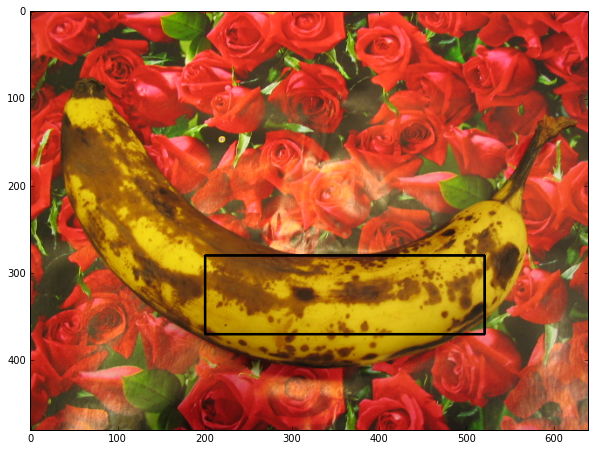

In [3]:
img_with_box = img.copy()
img_with_box = cv2.rectangle(img_with_box, (x1, y1), (x2, y2), 1, 2)

plt.figure(figsize=[10, 10])
img_plt = cv2.cvtColor(img_with_box, cv2.COLOR_BGR2RGB)
plt.imshow(img_plt)
plt.show()

In [4]:
def fit_gmm(data, K=5, verbose=False):
    def likelihood(means, covariances, mixing_proportions):
        # Compute data log-likelihood for the given GMM parametrization
        densities = np.array([mvn.pdf(data, means[k], covariances[k]) for k in range(K)])
        unnormalized_responsibilities = densities * mixing_proportions
        return np.log(unnormalized_responsibilities.sum(axis=0)).sum()

    data = data.reshape(-1, data.shape[-1])

    N = data.shape[0]
    D = data.shape[1] # Dimension of the data points
    
    # Initialize the variables that are to be learned
    covariances = np.array([100 * np.eye(D) for k in range(K)]) # Covariance matrices
    mixing_proportions = np.ones([K, 1]) / K # Mixing propotions
    responsibilities = np.zeros([N, K])
    
    # Choose the initial centroids using k-means clustering
    kmeans = KMeans(n_clusters=K)
    kmeans = kmeans.fit(data)
    means = kmeans.cluster_centers_
    
    old_likelihood = likelihood(means, covariances, mixing_proportions)
    
    if verbose:
        print("Likelihood after intialization: {0:.2f}".format(old_likelihood))
        
    # Iterate until convergence
    it = 0
    converged = False
    while not converged:
        it += 1
        old_likelihood = likelihood(means, covariances, mixing_proportions)

        # Compute the responsibilities
        densities = np.array([mvn.pdf(data, means[k], covariances[k]) for k in range(K)])
        responsibilities = densities * mixing_proportions
        responsibilities = (responsibilities / responsibilities.sum(axis=0)).T

        # Update the distribution parameters
        resp_sums = responsibilities.sum(axis=0)
        means = responsibilities.T.dot(data)
        for k in range(K):
            means[k] /= resp_sums[k]
            covariances[k] = np.zeros(D)
            for n in range(N):
                centered = data[n, :] - means[k]
                covariances[k] += responsibilities[n, k] * np.outer(centered, centered)
            covariances[k] /= resp_sums[k]
            covariances[k] += 0.1 * np.eye(D) # To prevent singular matrices
        mixing_proportions = np.reshape(resp_sums / N, [K, 1])

        # Check for convergence
        new_likelihood = likelihood(means, covariances, mixing_proportions)
        delta = new_likelihood - old_likelihood
        converged = delta < np.abs(new_likelihood) * 1e-4
        if verbose:
            print("Iteration {0}, likelihood = {1:.2f}, delta = {2:.2f}".format(it, new_likelihood, delta))
            
    return (means, covariances, mixing_proportions)

In [5]:
def show_segmented(img, means, covariances, mixing_proportions, threshold=1e-7, title=''):
    K = means.shape[0]
    flat_img = img.reshape([-1, img.shape[-1]])
    probas = np.array([mixing_proportions[k] * mvn.pdf(flat_img, means[k], covariances[k]) for k in range(K)]).T
    probas = probas.sum(axis=1)
    plt.figure(figsize=[10, 10])
    plt.imshow((probas > threshold).reshape(img.shape[:2]))
    plt.title(title)
    plt.show()

# GMM trained inside the box

In [6]:
in_box = img[y1: y2, x1: x2, :]

means, covariances, mixing_proportions = fit_gmm(in_box, K=5, verbose=True)

Likelihood after intialization: -364271.31
Iteration 1, likelihood = -339269.72, delta = 25001.59
Iteration 2, likelihood = -337294.30, delta = 1975.42
Iteration 3, likelihood = -336684.31, delta = 609.99
Iteration 4, likelihood = -336441.18, delta = 243.13
Iteration 5, likelihood = -336245.97, delta = 195.21
Iteration 6, likelihood = -336053.01, delta = 192.96
Iteration 7, likelihood = -335639.81, delta = 413.20
Iteration 8, likelihood = -332325.72, delta = 3314.09
Iteration 9, likelihood = -331542.02, delta = 783.70
Iteration 10, likelihood = -331404.63, delta = 137.39
Iteration 11, likelihood = -331319.42, delta = 85.21
Iteration 12, likelihood = -331253.15, delta = 66.27
Iteration 13, likelihood = -331195.16, delta = 57.99
Iteration 14, likelihood = -331141.44, delta = 53.72
Iteration 15, likelihood = -331091.23, delta = 50.20
Iteration 16, likelihood = -331045.04, delta = 46.19
Iteration 17, likelihood = -331003.24, delta = 41.80
Iteration 18, likelihood = -330965.61, delta = 37.6

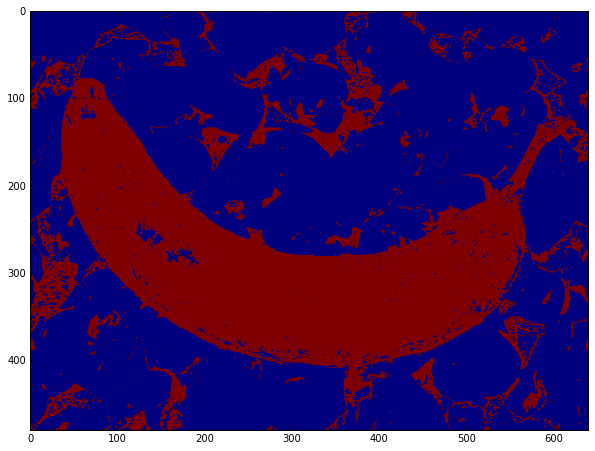

In [7]:
show_segmented(img, means, covariances, mixing_proportions)

# GMM trained outside the box

Really ugly way to select all the pixels that are not inside the bounding box

In [8]:
xrange = set(range(x1, x2))
yrange = set(range(y1, y2))

outside_box = []
for (x, y), val in np.ndenumerate(img[:, :, 0]):
    if x not in xrange and y not in yrange:
        outside_box.append(img[x, y, :])
        
outside_box = np.array(outside_box)

In [9]:
means, covariances, mixing_proportions = fit_gmm(outside_box, K=5, verbose=True)

Likelihood after intialization: -1828115.69
Iteration 1, likelihood = -1499252.81, delta = 328862.89
Iteration 2, likelihood = -1492004.99, delta = 7247.81
Iteration 3, likelihood = -1487231.94, delta = 4773.05
Iteration 4, likelihood = -1483410.46, delta = 3821.48
Iteration 5, likelihood = -1480336.02, delta = 3074.44
Iteration 6, likelihood = -1477806.64, delta = 2529.38
Iteration 7, likelihood = -1475503.81, delta = 2302.84
Iteration 8, likelihood = -1473032.20, delta = 2471.60
Iteration 9, likelihood = -1470991.18, delta = 2041.02
Iteration 10, likelihood = -1469643.49, delta = 1347.70
Iteration 11, likelihood = -1468669.49, delta = 974.00
Iteration 12, likelihood = -1467950.91, delta = 718.58
Iteration 13, likelihood = -1467410.47, delta = 540.44
Iteration 14, likelihood = -1466988.75, delta = 421.72
Iteration 15, likelihood = -1466649.09, delta = 339.66
Iteration 16, likelihood = -1466369.03, delta = 280.06
Iteration 17, likelihood = -1466130.65, delta = 238.38
Iteration 18, like

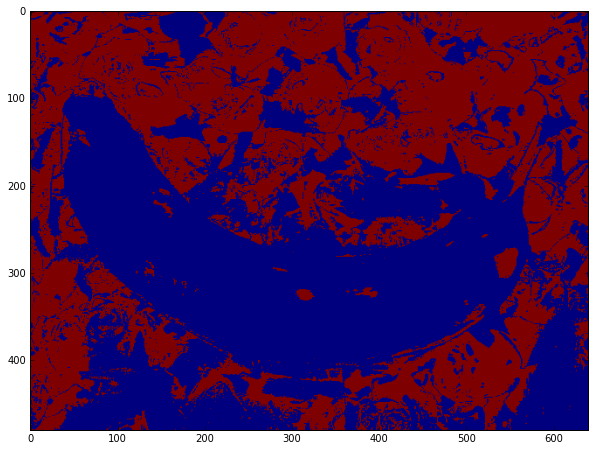

In [10]:
show_segmented(img, means, covariances, mixing_proportions, threshold=1e-6)